In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/nlp_20/weibo_sentiment_analysis-main")

## 数据处理、探索性分析、训练词向量模型

In [ ]:
import jieba
import pandas as pd
import numpy as np
import requests
import datetime
import hashlib
import base64
import hmac
import json
import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from pylab import mpl
import seaborn as sns
import missingno
%matplotlib inline

In [ ]:
class get_result(object):
    def __init__(self,host,text,BusinessArgs):
        # 应用ID（到控制台获取）
        self.APPID = "5f9bc6e9"
        # 接口APISercet（到控制台机器翻译服务页面获取）
        self.Secret = "b4e7b50787941dc5f125be32b60899fb"
        # 接口APIKey（到控制台机器翻译服务页面获取）
        self.APIKey= "6678ddb9a98bf9b4fcf570cf9f52c570"
        
        
        # 以下为POST请求
        self.Host = host
        self.RequestUri = "/v2/its"
        # 设置url
        # print(host)
        self.url="https://"+host+self.RequestUri
        self.HttpMethod = "POST"
        self.Algorithm = "hmac-sha256"
        self.HttpProto = "HTTP/1.1"

        # 设置当前时间
        curTime_utc = datetime.datetime.utcnow()
        self.Date = self.httpdate(curTime_utc)
        # 设置业务参数
        # 语种列表参数值请参照接口文档：https://www.xfyun.cn/doc/nlp/xftrans/API.html
        self.Text=text
        self.BusinessArgs=BusinessArgs


    def hashlib_256(self, res):
        m = hashlib.sha256(bytes(res.encode(encoding='utf-8'))).digest()
        result = "SHA-256=" + base64.b64encode(m).decode(encoding='utf-8')
        return result

    def httpdate(self, dt):
        """
        Return a string representation of a date according to RFC 1123
        (HTTP/1.1).

        The supplied date must be in UTC.

        """
        weekday = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"][dt.weekday()]
        month = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep",
                 "Oct", "Nov", "Dec"][dt.month - 1]
        return "%s, %02d %s %04d %02d:%02d:%02d GMT" % (weekday, dt.day, month,
                                                        dt.year, dt.hour, dt.minute, dt.second)

    def generateSignature(self, digest):
        signatureStr = "host: " + self.Host + "\n"
        signatureStr += "date: " + self.Date + "\n"
        signatureStr += self.HttpMethod + " " + self.RequestUri \
                        + " " + self.HttpProto + "\n"
        signatureStr += "digest: " + digest
        signature = hmac.new(bytes(self.Secret.encode(encoding='utf-8')),
                             bytes(signatureStr.encode(encoding='utf-8')),
                             digestmod=hashlib.sha256).digest()
        result = base64.b64encode(signature)
        return result.decode(encoding='utf-8')

    def init_header(self, data):
        digest = self.hashlib_256(data)
        #print(digest)
        sign = self.generateSignature(digest)
        authHeader = 'api_key="%s", algorithm="%s", ' \
                     'headers="host date request-line digest", ' \
                     'signature="%s"' \
                     % (self.APIKey, self.Algorithm, sign)
        #print(authHeader)
        headers = {
            "Content-Type": "application/json",
            "Accept": "application/json",
            "Method": "POST",
            "Host": self.Host,
            "Date": self.Date,
            "Digest": digest,
            "Authorization": authHeader
        }
        return headers

    def get_body(self):
        content = str(base64.b64encode(self.Text.encode('utf-8')), 'utf-8')
        postdata = {
            "common": {"app_id": self.APPID},
            "business": self.BusinessArgs,
            "data": {
                "text": content,
            }
        }
        body = json.dumps(postdata)
        #print(body)
        return body

    def call_url(self):
        if self.APPID == '' or self.APIKey == '' or self.Secret == '':
            print('Appid 或APIKey 或APISecret 为空！请打开demo代码，填写相关信息。')
        else:
            code = 0
            body=self.get_body()
            headers=self.init_header(body)
            #print(self.url)
            response = requests.post(self.url, data=body, headers=headers,timeout=8)
            status_code = response.status_code
            #print(response.content)
            if status_code!=200:
                # 鉴权失败
                print("Http请求失败，状态码：" + str(status_code) + "，错误信息：" + response.text)
                print("请根据错误信息检查代码，接口文档：https://www.xfyun.cn/doc/nlp/xftrans/API.html")
            else:
                # 鉴权成功
                respData = json.loads(response.text)
                return respData['data']['result']['trans_result']['dst']
                # 以下仅用于调试
                code = str(respData["code"])
                if code!='0':
                    print("请前往https://www.xfyun.cn/document/error-code?code=" + code + "查询解决办法")



In [ ]:
def retrans(text):
    host = "itrans.xfyun.cn"
    Args1={"from": "cn","to": "en",}
    Args2={"from": "en","to": "cn",}
    gClass1=get_result(host,text=text,BusinessArgs=Args1)
    trans=gClass1.call_url()
    
    gClass2=get_result(host,text=trans,BusinessArgs=Args2)
    return gClass2.call_url()

In [ ]:
#data=pd.read_csv("multi.csv",usecols=['title','fact','opinion','inhibition','fff','activation','moral'])
#读入原始数据
weibodata=pd.read_csv("labeledData.csv",usecols=['review','label'])

In [ ]:
#导入停用词
stopwords=pd.read_csv("cn_stopwords.txt",encoding='utf-8',engine='python')

In [ ]:
#定义函数，jieba分词，去停用词
def cut_stop(prelist):
    l=[i for i in jieba.lcut(prelist) if i not in stopwords]
    return l
    

In [ ]:
#test['trans']=test['title'].apply(retrans)

In [ ]:
#data['cut']=[cut_stop(i) for i in data['title'].astype(str)]
#将review中的内容进行分词和去停用词
weibodata['cut']=[cut_stop(i) for i in weibodata['review'].astype(str)] 
#分词，不去停用词
weibodata['fullcut']=weibodata['review'].apply(lambda x: jieba.lcut(x))

In [ ]:
#data['length']=[ len(i) for i in data['cut']]
#去停用词后的词汇长度
weibodata['length']=[len(i) for i in weibodata['cut']]

In [ ]:
#数据量为21173行
weibodata

,review,label,cut,fullcut,length
0,不过，喜欢4.0原生态的界面！,2,"[不过, ，, 喜欢, 4.0, 原生态, 的, 界面, ！]","[不过, ，, 喜欢, 4.0, 原生态, 的, 界面, ！]",8
1,又要重复我每年必说的台词了，2010就要过去了，我很怀念它。,2,"[又, 要, 重复, 我, 每年, 必说, 的, 台词, 了, ，, 2010, 就要, 过...","[又, 要, 重复, 我, 每年, 必说, 的, 台词, 了, ，, 2010, 就要, 过...",20
2,至少，它看上去很美。,2,"[至少, ，, 它, 看上去, 很, 美, 。]","[至少, ，, 它, 看上去, 很, 美, 。]",7
3,这家位于槟城George Town，Tunes Hotel斜对面的饼家，家庭式作业，她的咸蛋...,2,"[这家, 位于, 槟城, George, , Town, ，, Tunes, , Hot...","[这家, 位于, 槟城, George, , Town, ，, Tunes, , Hot...",36
4,很野味哦。。。,2,"[很, 野味, 哦, 。, 。, 。]","[很, 野味, 哦, 。, 。, 。]",6
...,...,...,...,...,...
21168,每次看到这种新闻都挺难受的,6,"[每次, 看到, 这种, 新闻, 都, 挺, 难受, 的, ]","[每次, 看到, 这种, 新闻, 都, 挺, 难受, 的, ]",9
21169,无语了 那就祝你们健康吧 ​,6,"[无语, 了, , 那, 就, 祝你们, 健康, 吧, , ​]","[无语, 了, , 那, 就, 祝你们, 健康, 吧, , ​]",10
21170,哈，安倍的话没人听，这真的是无语，是心大呢，还是有信心呢 ​,6,"[哈, ，, 安倍, 的话, 没人, 听, ，, 这, 真的, 是, 无语, ，, 是, 心...","[哈, ，, 安倍, 的话, 没人, 听, ，, 这, 真的, 是, 无语, ，, 是, 心...",22
21171,乱带节奏呢？真以为大家看不懂日语吗？京都教育局意思是疫情来得太突然，本来决定3月2日正常上课...,6,"[乱带, 节奏, 呢, ？, 真, 以为, 大家, 看不懂, 日语, 吗, ？, 京都, 教...","[乱带, 节奏, 呢, ？, 真, 以为, 大家, 看不懂, 日语, 吗, ？, 京都, 教...",59


In [ ]:
#查看列的数据类型
weibodata.dtypes

review     object
label       int64
cut        object
fullcut    object
length      int64
dtype: object

In [ ]:
weibodata[["label"]] = weibodata[["label"]].astype(object)

In [ ]:
weibodata.dtypes

review     object
label      object
cut        object
fullcut    object
length      int64
dtype: object

In [ ]:
weibodata.loc[:,'label'].value_counts()

2    3595
0    3227
6    3175
3    3145
4    3072
5    2756
1    2203
Name: label, dtype: int64

In [ ]:
#仅有一个数值型数据，查看其分布
weibodata.describe()

,length
count,21173.000000
mean,18.701034
std,17.472041
min,1.000000
25%,8.000000
50%,13.000000
75%,24.000000
max,531.000000


In [ ]:
#查看label的分布
weibodata["label"].describe()

count     21173
unique        7
top           2
freq       3595
Name: label, dtype: int64

In [ ]:
#np.mean(weibodata['length'])

In [ ]:
#np.median(weibodata['length'])

In [ ]:
#去掉那些超过100个分词的微博行
weibodata=weibodata.drop(weibodata[weibodata.length>100].index)
#data=data.drop(data[data.length>200 ].index)

In [ ]:
#np.mean(data['length'])

In [ ]:
#np.median(data['length'])

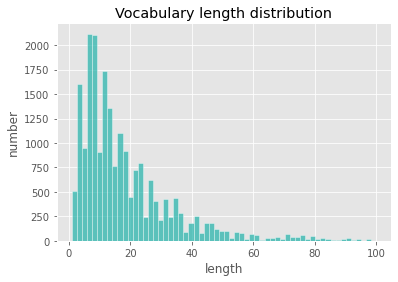

In [ ]:
#查看最终分好的词汇长度分布
da=weibodata['length'].tolist()
plt.hist(da, bins=60, facecolor="lightseagreen", edgecolor="white", alpha=0.7)
matplotlib.rcParams['font.sans-serif']=['SimHei']
plt.xlabel("length")
 # 显示纵轴标签
plt.ylabel("number")
 # 显示图标题
plt.title("Vocabulary length distribution")

plt.show()

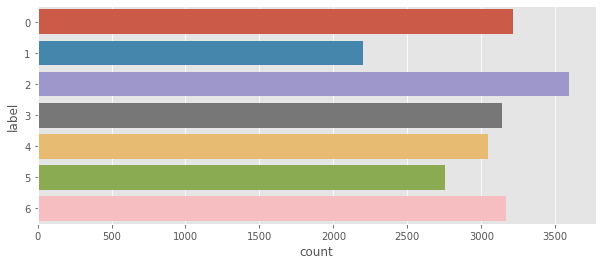

In [ ]:
# g = sns.countplot(y=weibodata["label"], data=weibodata)
# plt.xticks(rotation=25)
plt.style.use("ggplot")
# plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,4)) 
sns.countplot(y="label", data=weibodata)

In [ ]:
from gensim.models import word2vec
import gensim

In [ ]:
sentences=weibodata['fullcut'].tolist()

In [ ]:
#gensim中word2Vec的输入是经过分词之后的list
model=word2vec.Word2Vec(sentences,min_count=1)

In [ ]:
model=word2vec.Word2Vec(sentences,min_count=1,size=100) #mincount表示考虑出现多少次的词语，是一个阈值,size表示神经网络层数，默认是100，也是输出的词向量的维度

In [ ]:
model.save("weibomodel")

In [ ]:
vocab=model.wv.vocab    #输出待向量化的词的个数
vectors=model.wv.vectors  #每个词向量化的结果，默认是100个维度
#wv类中包含了从word到embedding之间的mapping

In [ ]:
words = list(vocab)
print(words[:10])

['不过', '，', '喜欢', '4.0', '原生态', '的', '界面', '！', '又', '要']
<built-in method count of list object at 0x7f564b65cb88>


In [ ]:
vector_of_word = list(vectors)

In [ ]:
vector_of_word[:1]

[array([-0.08941045,  0.8815137 ,  0.22423284,  1.301808  , -0.38623977,
         0.7955887 , -0.25446048,  0.43639833,  1.4805135 ,  1.0143374 ,
         0.19054219,  0.7753705 , -0.3473857 , -0.75147814, -0.08918763,
         0.94671303, -0.09626184,  0.48189798, -0.4397087 ,  0.16746238,
        -0.62504697,  0.966422  ,  0.13364996,  0.23574805,  0.7639215 ,
        -0.25253686,  1.7848331 ,  1.029789  , -0.9389517 , -1.013632  ,
         1.1545194 , -0.1907085 , -0.06685413, -0.14781694, -1.1790082 ,
        -0.28049657,  0.75420254,  0.11253154, -0.27368498, -0.23725362,
         1.0073469 ,  0.16747214,  0.81370616, -0.19725592, -0.22592661,
        -0.54537576, -0.1990937 , -0.8245643 , -0.279994  , -1.0563257 ,
        -1.9422777 ,  0.88709605,  0.42822295,  0.06521569,  0.8506413 ,
         0.59840983,  1.766176  , -0.66350937, -0.34299296,  0.5987658 ,
         0.13434778, -0.88001597, -0.71093404, -0.71720415, -0.13492121,
        -0.0583229 , -0.9697922 ,  1.2691672 , -0.4

In [ ]:
#将word和vector写入 "wvmodel.txt"
with open("wvmodel.txt",'w',encoding='utf-8') as f:
    f.write(str(vectors.shape[0]))
    f.write(" ")
    f.write(str(vectors.shape[1]))
    f.write("\n")
    for voc,vec in zip(vocab,vectors):
        f.write(str(voc)+" ")
        f.write(" ".join(str(i) for i in vec))
        f.write("\n")
        

In [ ]:
weibodata.to_csv("weibodata.csv")

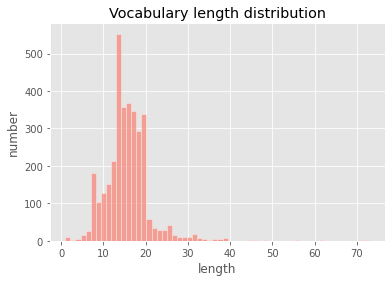

In [ ]:
data=pd.read_csv("multi.csv",usecols=['title','fact','opinion','inhibition','fff','activation','moral']) #读入另一个文本文件
data['cut']=[cut_stop(i) for i in data['title'].astype(str)]   #使用定义好的jieba分词，去停用词
data['length']=[ len(i) for i in data['cut']] #获取分词之后得到的各行的单词长度
data=data.drop(data[data.length>200 ].index) #去掉分词之后长度大于200的词

da=data['length'].tolist() 
plt.hist(da, bins=60, facecolor="salmon", edgecolor="white", alpha=0.7)
matplotlib.rcParams['font.sans-serif']=['SimHei']
plt.xlabel("length")
 # 显示纵轴标签
plt.ylabel("number")
 # 显示图标题
plt.title("Vocabulary length distribution")

plt.show()

In [ ]:
data=data.drop(data[data.length>30 ].index) #发现超过30长度的数据量很少，于是删除

In [ ]:
data.to_csv("yqdata.csv")